## AI Lifecycle - Final project
### Data processing
In this notebook the data that is used in final project is processed and prepared for training.  Included in the processing steps are image processing, data splitting and data augmentation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import time
import pickle
from skimage import color
from skimage import io

In [ ]:
+from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/

/content/drive/My Drive


In [ ]:
cd lokaverkefni/

/content/drive/My Drive/lokaverkefni


In [ ]:
cd Original/

/content/drive/My Drive/lokaverkefni/Original


### Reading the data
The data includes images otoliths from 8 different regions in Alaska, the aim of the project is to build a model that can classify the fish to regions by their otolith's shape.

In [ ]:
locations = ['DouglasReef', 'Iniskin', 'Kayak_Island', 'KukakBay', 'Uganik', 'Landlocked',
             'Stockdale', 'RockyBay']

y = [] # labels
x = [] # images(RGB)

cwd = os.getcwd()
for subdir, dirs, files in os.walk(cwd):
  if len(files) != 0:
    for l in locations:
      if l in subdir:
        location = l
        print(location)
        break

    for f in files:
      filepath = f'{subdir}/{f}'
      
      try:
        img = Image.open(filepath)
        new_filepath = f"../test_imgs/{location}_{filepath.split('/')[-1]}"

        img_dat = np.array(img)
        x.append(img_dat) # full quality imgs
        y.append([locations.index(location), filepath, new_filepath]) # label, img object, new_filepath if in test later on
      
      except:
        print(filepath)


      


Uganik
Stockdale
Landlocked
RockyBay
Kayak_Island
KukakBay
KukakBay
Landlocked
RockyBay
Kayak_Island
Iniskin
DouglasReef
DouglasReef
Iniskin


### Data split
Split the data 70-15-15, Train, Test, Validation. The images from the testing set are saved to a folder in original resolution.

In [ ]:
# data split, y_test left out for model evaluation later on

x_train, x_te, y_train, y_te = train_test_split(x, y, test_size = 0.3, random_state = 42)

# free up memory
del x[:]
del y[:]

del x
del y

x_test, x_val, y_test, y_val = train_test_split(x_te, y_te, test_size = 0.5, random_state = 42)

del x_te[:]
del x_te

del y_te[:]
del y_te

def save_test_imgs():
  # save test images in full quality rgb
  for i in y_test:
    img = Image.open(i[1])
    img.save(i[2], 'JPEG')

save_test_imgs()

y_test_labels = [i[0] for i in y_test]
del y_test[:]
del y_test

y_train_labels = [i[0] for i in y_train]
del y_train[:]
del y_train

y_val_labels = [i[0] for i in y_val]
del y_val[:]
del y_val

### Image processing
The images from some of the regions have a visible yellow-ish frame, an attempt to crop this frame out of the images in the training set is made. The frame, if present is kept in the images from the testing and validation data. All of the images are resized and converted to grayscale and back to rgb.

In [ ]:
def has_noise(img):
  # img is grayscale
  # detects if image includes a yellow frame
  avg_top = np.mean(img[0:20, 0:img.shape[1]])
  avg_bottom = np.mean(img[-20:, 0:img.shape[1]])

  noise = {'top':False, 'bottom':False}
  noise_bool = False

  if avg_top> 50:
    noise_bool = True
    noise['top'] = True
  
  if avg_bottom> 50:
    noise_bool = True
    noise['bottom'] = True
  

  return noise, noise_bool

def remove_noise(img, noise_dict):

  # takes in a grayscale image with otolith and tries to remove the yellow frame
  # surrounding the image
  h, w = img.shape
  top_cut = 0
  bottom_cut = h
  left_cut = 0
  right_cut = w
  flag = False
  
  if noise_dict['top']:
    while True:
      avg_section = np.mean(img[top_cut:top_cut+10, 0:w])
      if avg_section < 10:
        break
      if top_cut + 10 >= h/2: # image not proper
        flag = True
        break
      top_cut += 10
  
  if noise_dict['bottom']:
    while True:
      avg_section = np.mean(img[bottom_cut-10:bottom_cut, 0:w])
      if avg_section < 10:
        break
      if bottom_cut -10 <= h/2: # image not proper
        flag = True
        break

      bottom_cut -= 10
  

  image_out = img[top_cut:bottom_cut, left_cut:right_cut]
    
  return image_out, flag

# resizing layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(280, 400),
  layers.experimental.preprocessing.Rescaling(1./255)
])


# it might seem strange to convert back to rgb since it takes 
# a lot more space but have to do it for keras pretrained models

def train_process(img):
  # to grayscale -> plocks border if exists -> resize down
  img_out = color.rgb2gray(img)
  img_out *= 255
  img_out.astype(np.uint8)
  f = False

  noise_dict, noise = has_noise(img_out)
  if noise:
    img_out, f = remove_noise(img_out, noise_dict)

  img_resize = resize_and_rescale(color.gray2rgb(img_out))
  return img_resize, f

def test_process(img):
  img_out = color.rgb2gray(img)
  img_out *= 255
  img_out.astype(np.uint8)

  img_resize = resize_and_rescale(color.gray2rgb(img_out))
  return img_resize


#### The output from the following chunk shows how the training images are processed.



Original image:



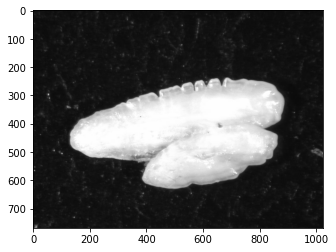

Image Grayscale:



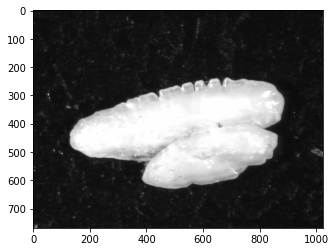

Image resized:



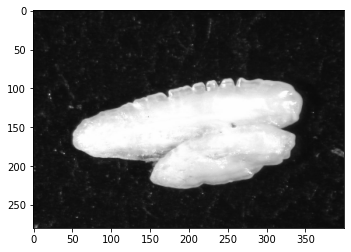



Original image:



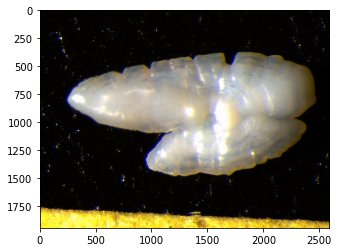

Image Grayscale:



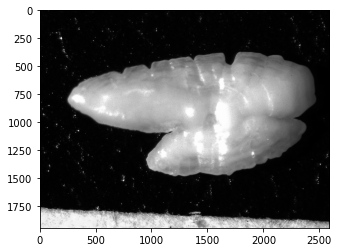

Flag False
Image cleaned:



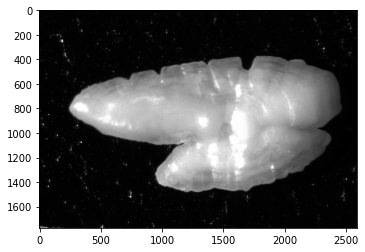

Image resized:



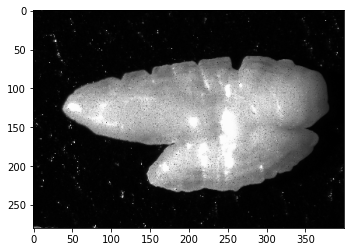



Original image:



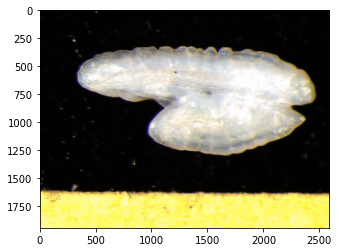

Image Grayscale:



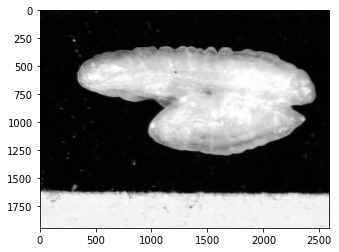

Flag False
Image cleaned:



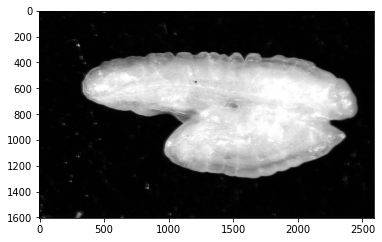

Image resized:



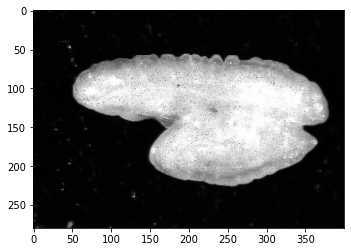



Original image:



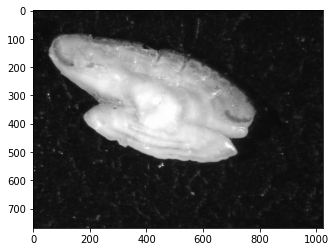

Image Grayscale:



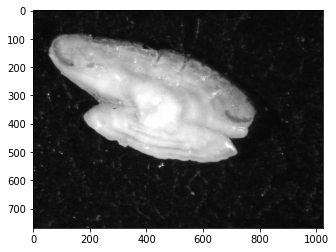

Image resized:



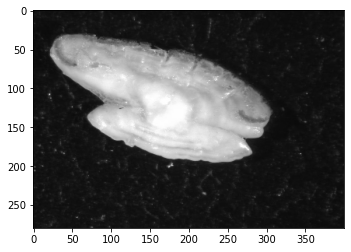



Original image:



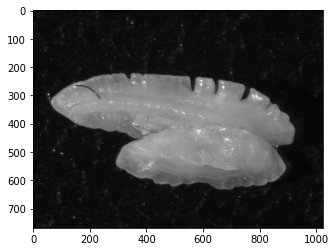

Image Grayscale:



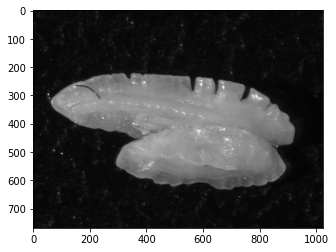

Image resized:



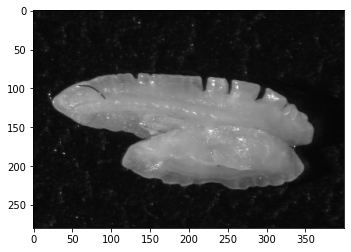



Original image:



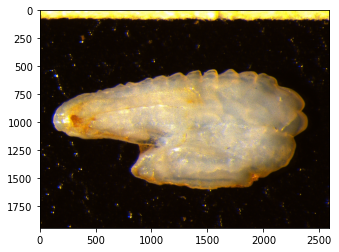

Image Grayscale:



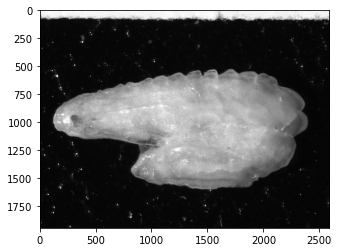

Flag False
Image cleaned:



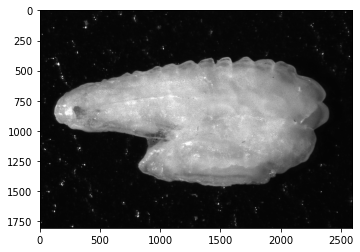

Image resized:



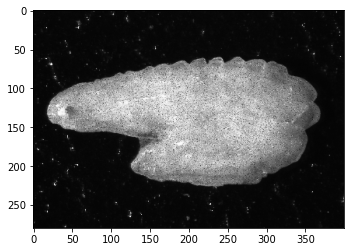



Original image:



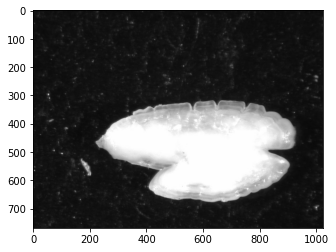

Image Grayscale:



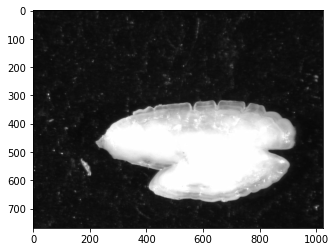

Image resized:



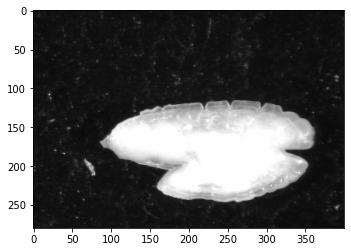



Original image:



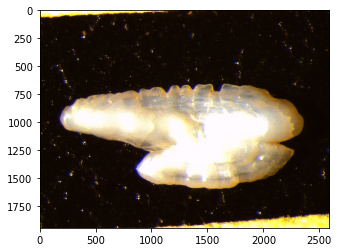

Image Grayscale:



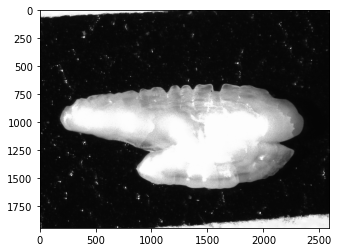

Flag False
Image cleaned:



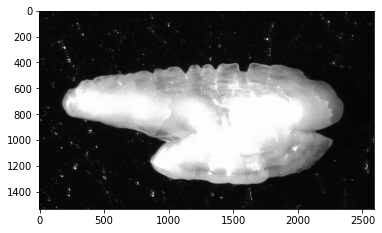

Image resized:



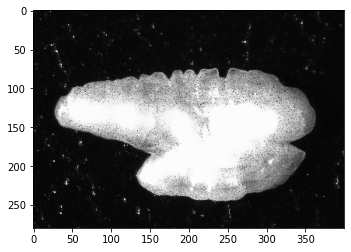



Original image:



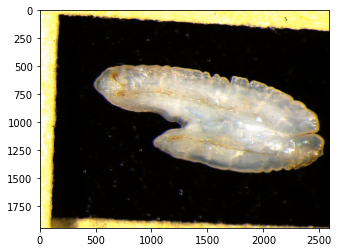

Image Grayscale:



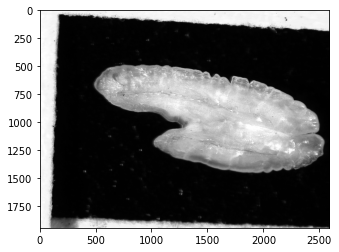

Flag True
Image cleaned:



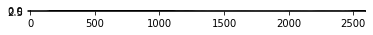

Image resized:



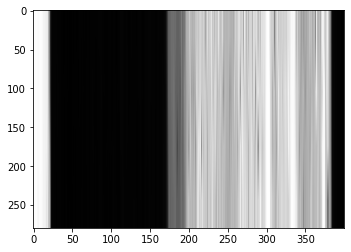



Original image:



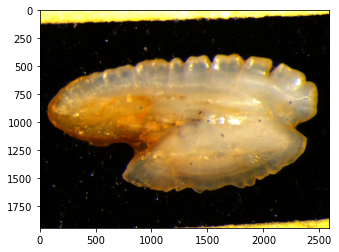

Image Grayscale:



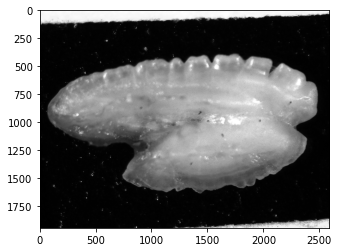

Flag False
Image cleaned:



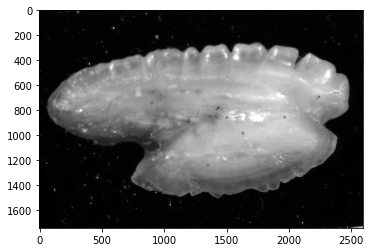

Image resized:



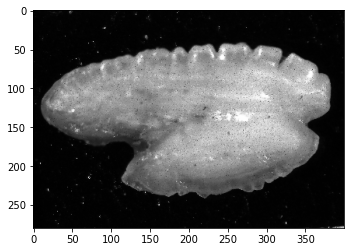

In [ ]:
# process x_train and x_test

# example of how images are processed
for i in range(10):
  print('\n')
  img = x_train[i]
  print('Original image:\n')
  plt.imshow(img)
  plt.show()
  
  img_gray = color.rgb2gray(img)
  img_gray *= 255
  img_gray.astype(np.uint8)
  print('Image Grayscale:\n')
  plt.imshow(img_gray, cmap = plt.cm.gray)
  plt.show()

  noise_dict, is_noisy = has_noise(img_gray)
  if is_noisy:
    img_cleaned, f = remove_noise(img_gray, noise_dict)
    print('Flag', f)
    print('Image cleaned:\n')
    plt.imshow(img_cleaned, cmap = plt.cm.gray)
    plt.show()
    
    print('Image resized:\n')
    img_resize = resize_and_rescale(color.gray2rgb(img_cleaned))
    plt.imshow(img_resize)
    plt.show()
  else:
    print('Image resized:\n')
    img_resize = resize_and_rescale(color.gray2rgb(img_gray))
    plt.imshow(img_resize)
    plt.show()



Process training images:

len train: 630
len off: 27
len in: 603
0 DouglasReef 120
1 Iniskin 98
2 Kayak_Island 62
3 KukakBay 91
4 Uganik 42
5 Landlocked 92
6 Stockdale 20
7 RockyBay 78


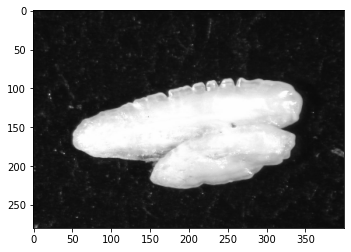

Process testing images:



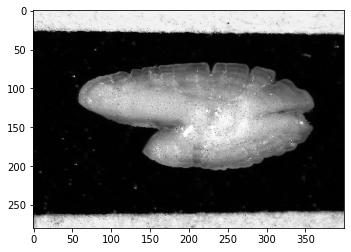

Process validation images:



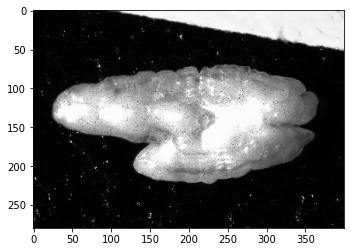

In [ ]:
print('Process training images:\n')

print('len train:', len(x_train))

# have to do it iteratively
x_tr = []
idx_off = []
x_off = []
idx_in = []
for i in range(len(x_train)):
    x_i, f = train_process(x_train[i])
    if f:
      x_off.append(x_train[i])
      idx_off.append(i)
    else:
      x_tr.append(x_i)
      idx_in.append(i)

print('len off:',len(idx_off))
print('len in:',len(idx_in))

y_train_labels = [y_train_labels[i] for i in idx_in]

del x_train[:]
del x_train

x_train = x_tr

for i in range(8):
  print(i,locations[i], y_train_labels.count(i))

# x_train = np.array([train_process(x_i) for x_i in x_train])
plt.imshow(x_train[0], cmap = plt.cm.gray)
plt.show()

print('Process testing images:\n')
x_test = np.array([test_process(x_i) for x_i in x_test])
plt.imshow(x_test[0], cmap = plt.cm.gray)
plt.show()

print('Process validation images:\n')
x_val = np.array([test_process(x_i) for x_i in x_val])
plt.imshow(x_val[0], cmap = plt.cm.gray)
plt.show()

#### The processing function can't be applied to some images because of how the frame is placed, the output from the following chunks shows examples of such images.

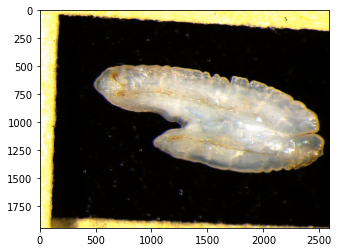

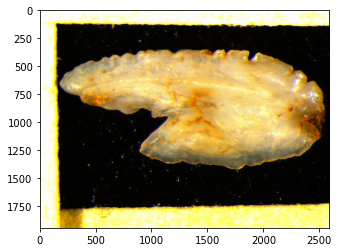

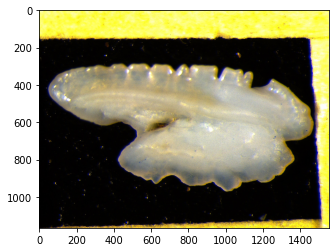

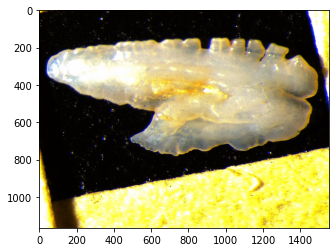

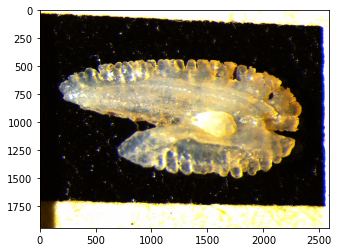

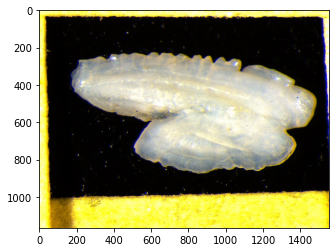

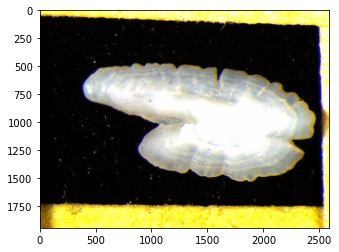

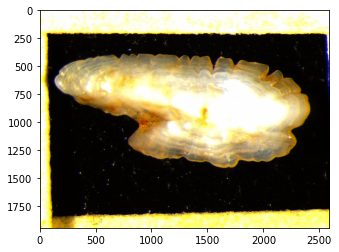

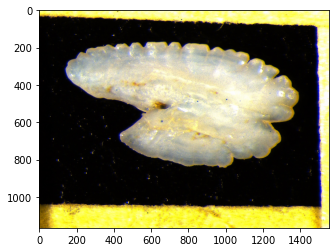

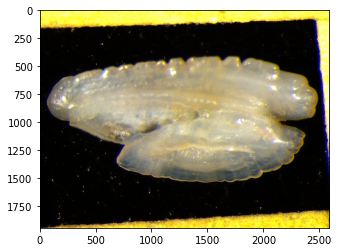

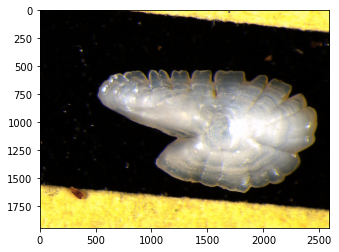

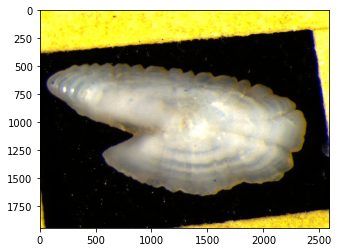

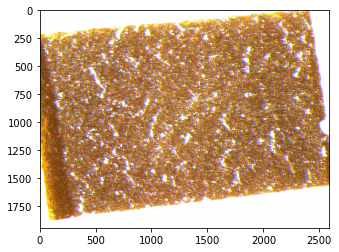

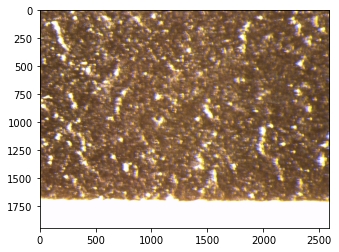

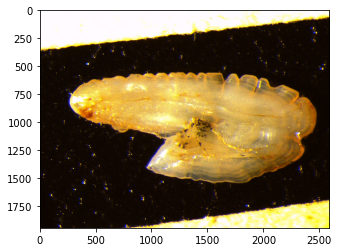

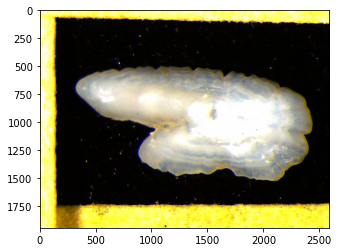

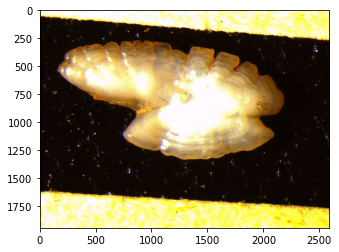

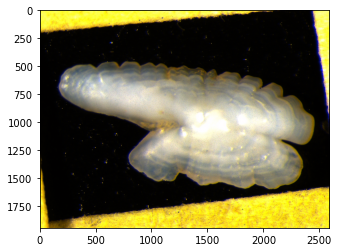

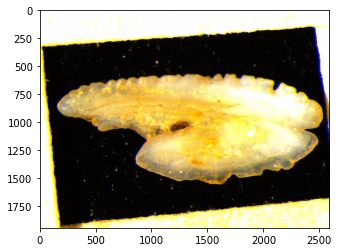

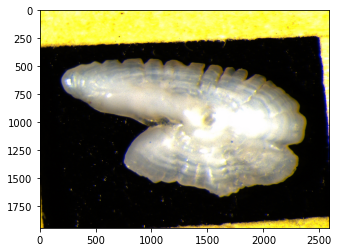

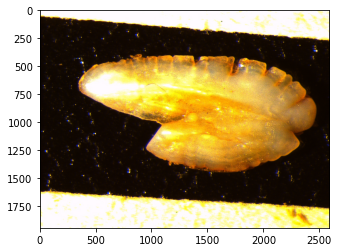

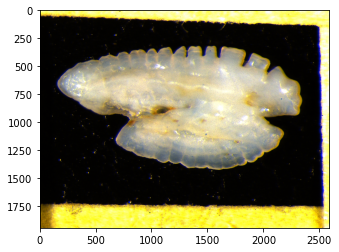

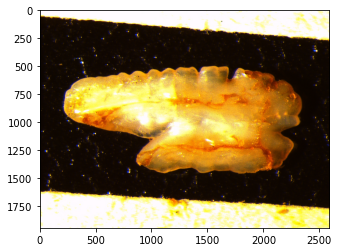

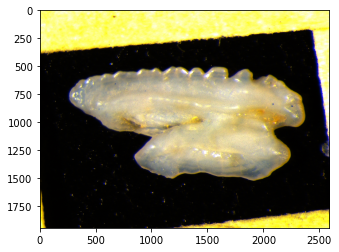

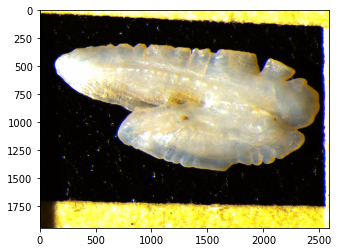

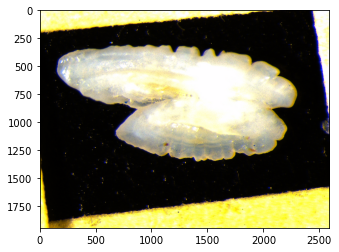

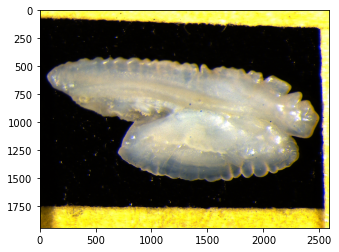

In [ ]:
for x in x_off:
  plt.imshow(x)
  plt.show()

### Data Augmentation
There is not enough data to train a complex model. Therefore we augment the training set by zooming and rotating images from the training set. By doing this we increase the size of the training set from 630 images to over 8000 images. The output from the following chunk shows how images from the training set can be transformed for data augmentation. 

Example of how data augmentation works


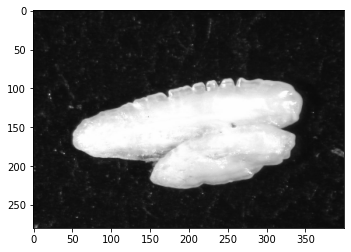

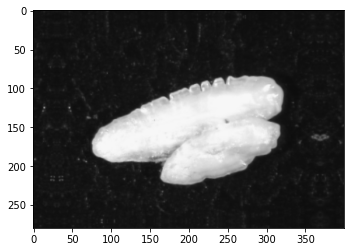

...



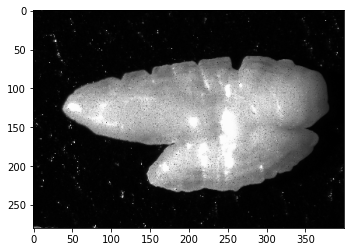

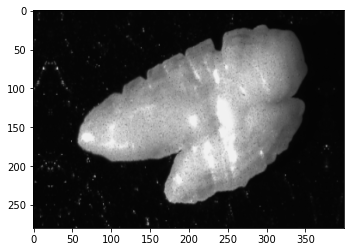

...



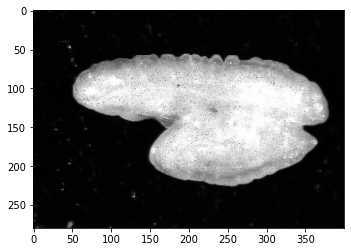

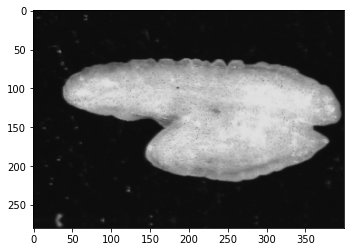

...



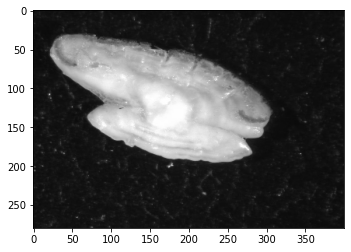

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


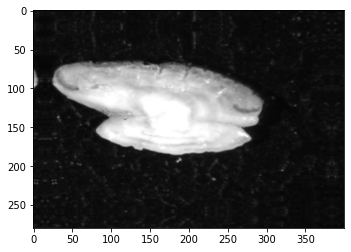

...



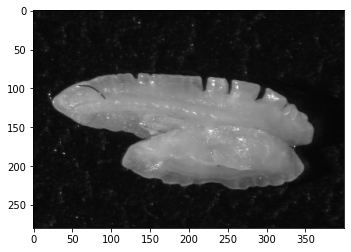

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


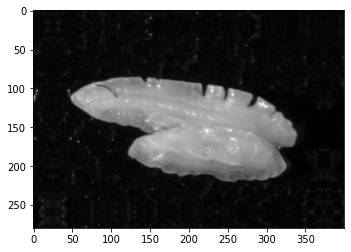

...



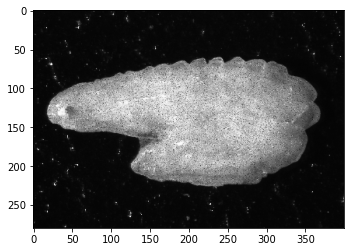

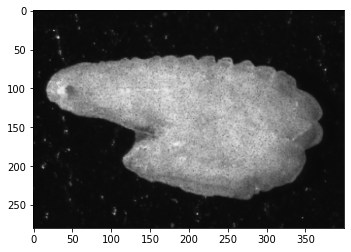

...



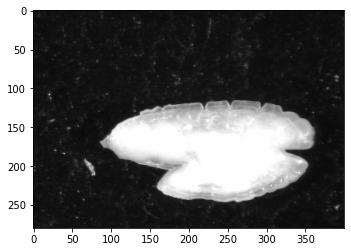

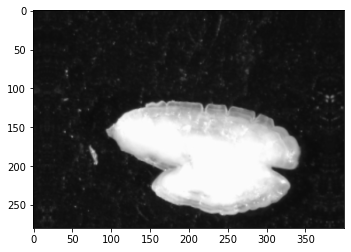

...



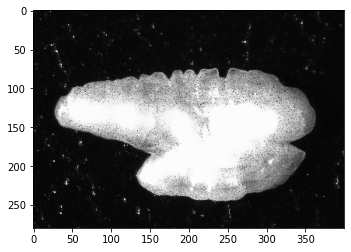

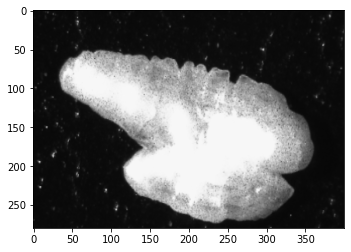

...



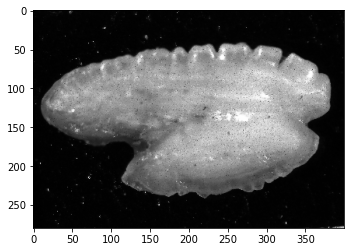

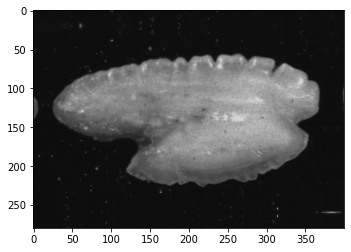

...



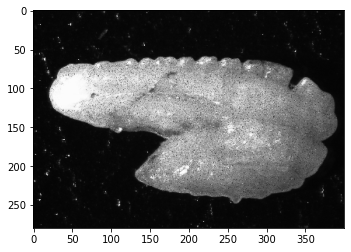

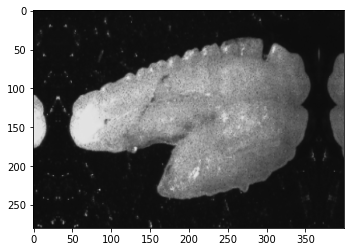

...



In [ ]:

data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomRotation(0.045),
      layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
      layers.experimental.preprocessing.RandomContrast(0.4)                                 
])

print('Example of how data augmentation works')
for i in range(10):
  aug_img = data_augmentation(tf.expand_dims(x_train[i],0))
  plt.imshow(x_train[i])
  plt.show()
  plt.imshow(aug_img[0])
  plt.show()
  print('...\n')

In [ ]:
def get_aug_imgs(batch_size, x_pop, y_pop):
  # batch_size: int, number of images
  # x pop: population to augment image data from
  # y pop: corresponding labels to x_pop

  y_out = []
  x_out = []

  for _ in range(batch_size):
    i = np.random.randint(len(x_pop))
    aug_img = data_augmentation(tf.expand_dims(x_pop[i],0))
    x_out.append(aug_img[0])
    y_out.append(y_pop[i])
  
  return x_out, y_out

start_time = time.time()
x_aug_train, y_aug_train = get_aug_imgs(8000, x_train, y_train_labels)
x_train += x_aug_train
y_train_labels += y_aug_train
print('Running time for 8000 examples:', time.time()-start_time)
del x_aug_train[:]
del x_aug_train


Running time for 8000 examples: 124.64667654037476


#### Save data ready for model training.

In [ ]:
np.savez('model_data', x_tr = np.array(x_train), x_te = np.array(x_test),
         y_tr = np.array(y_train_labels), y_te = np.array(y_test_labels), x_val = np.array(x_val),
         y_val = np.array(y_val_labels))